In [1]:
%load_ext autoreload
%autoreload 2
import os
import random
from collections import OrderedDict, defaultdict
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose, Normalize
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from mnist import MNIST, MNISTTrain, MNISTTest

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## Dataloader

In [2]:
batch_size = 1024 * 4

In [3]:
train_loader = DataLoader(dataset=MNISTTrain(transform=Compose([ToTensor(),])),
                          batch_size=batch_size, shuffle=True, num_workers=2)

In [4]:
test_loader = DataLoader(dataset=MNISTTest(transform=Compose([ToTensor(),])),
                          batch_size=batch_size, shuffle=False)


## Model

In [5]:
class Encoder(nn.Module):
    
    def __init__(self, hiddens, zdim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, hiddens[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hiddens[0], hiddens[1]), 
            nn.ReLU(), 
            nn.Dropout(dropout),
            nn.Linear(hiddens[1], zdim)
            )
    
    def forward(self, x):
        x = x.squeeze().view(-1, 784)
        return self.net(x)
        

In [6]:
class Decoder(nn.Module):
    
    def __init__(self, zdim, hiddens, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(zdim, hiddens[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hiddens[0], hiddens[1]), 
            nn.ReLU(), 
            nn.Dropout(dropout),
            nn.Linear(hiddens[1], 784),
            )
    
    def forward(self, z):
        return self.net(z)
        

In [7]:
class AutoEncoder(nn.Module):
    
    def __init__(self, ):
        super().__init__()
        self.zdim = 50
        self.encoder = Encoder(hiddens=[400, 200], zdim=self.zdim)
        self.decoder = Decoder(hiddens=[400, 784], zdim=self.zdim,)
        
        self.apply(self.reset_parameters)
    
    def reset_parameters(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight, )
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.)
            
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    

In [8]:
def train():
    model = AutoEncoder().cuda()
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.98) 
    epochs = 50
    losses = []
    it = 0
    for i in range(epochs):
        print("Starting Epoch ", i, "...")
        for j, (img, label) in enumerate(train_loader):
            img = img.cuda()
            img /= 255.0
            out = model(img)
            # print(out[0])
            # print(img[0].squeeze())
            out = out.view(img.size())
            loss = F.binary_cross_entropy_with_logits(out, img, reduction="mean")
            optimizer.zero_grad()
            loss.backward()
            it += 1
            optimizer.step()
            losses.append(loss.item())
            if it % 100 == 0:
                print(f"Epoch: {i}, batch: {j}, loss: {np.mean(losses[-100:])}")
        scheduler.step()

    return model, losses
    
        

In [9]:
model, losses = train()

Starting Epoch  0 ...
Starting Epoch  1 ...
Epoch: 1, batch: 40, loss: 0.3261484661698341
Starting Epoch  2 ...
Starting Epoch  3 ...
Epoch: 3, batch: 22, loss: 0.21498456090688706
Starting Epoch  4 ...
Starting Epoch  5 ...
Epoch: 5, batch: 4, loss: 0.18505219161510467
Starting Epoch  6 ...
Epoch: 6, batch: 45, loss: 0.17320035830140112
Starting Epoch  7 ...
Starting Epoch  8 ...
Epoch: 8, batch: 27, loss: 0.16659822434186936
Starting Epoch  9 ...
Starting Epoch  10 ...
Epoch: 10, batch: 9, loss: 0.1620730924606323
Starting Epoch  11 ...
Epoch: 11, batch: 50, loss: 0.15866385877132416
Starting Epoch  12 ...
Starting Epoch  13 ...
Epoch: 13, batch: 32, loss: 0.15630590185523033
Starting Epoch  14 ...
Starting Epoch  15 ...
Epoch: 15, batch: 14, loss: 0.15451511085033418
Starting Epoch  16 ...
Epoch: 16, batch: 55, loss: 0.15313492327928543
Starting Epoch  17 ...
Starting Epoch  18 ...
Epoch: 18, batch: 37, loss: 0.15186309337615966
Starting Epoch  19 ...
Starting Epoch  20 ...
Epoch: 2

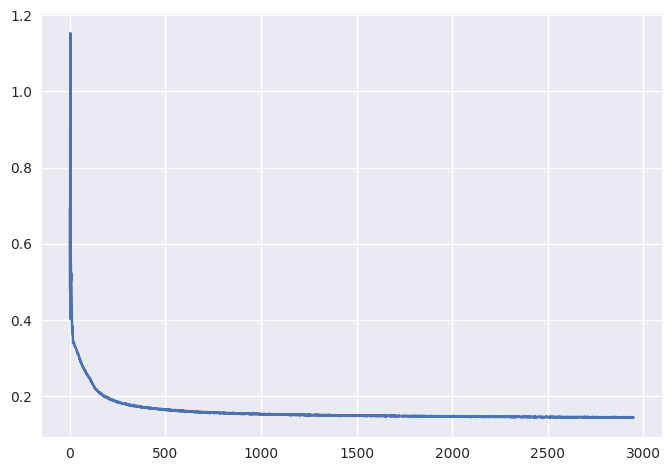

In [10]:
plt.plot(losses)

In [11]:
with torch.no_grad():
    model.eval()
    for j, (img, label) in enumerate(test_loader):
        img = img.cuda()
        img /= 255.0
        out = model(img)
        out = out.view(img.size())
        out = out.detach().cpu().permute(0, 2, 3, 1)
        
        break

In [12]:
label

tensor([0, 9, 7,  ..., 7, 0, 6])

In [13]:
def plot_images(idx):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img[idx].permute(1, 2, 0).detach().cpu())
    ax2.imshow(torch.sigmoid(out[idx].cpu()))
    fig.suptitle(label[idx].item())

In [14]:
img.size()

torch.Size([4096, 1, 28, 28])

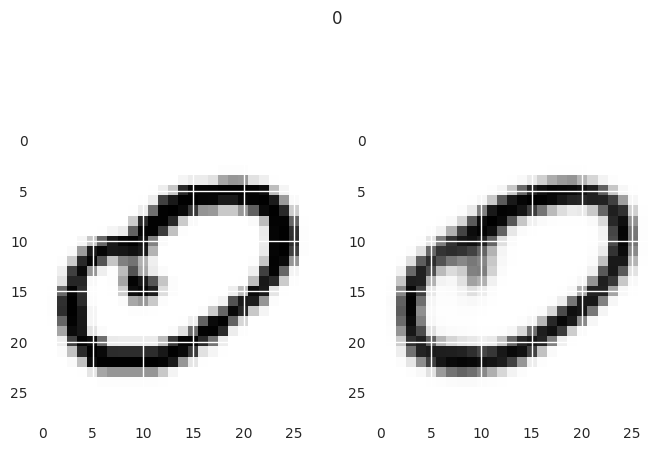

In [15]:
plot_images(0)

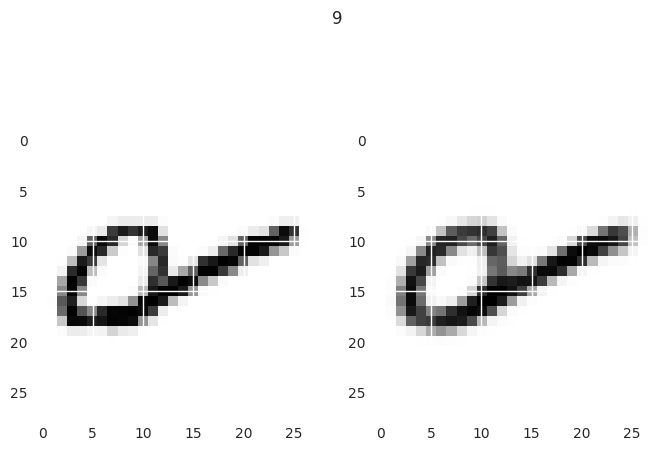

In [16]:
plot_images(1)

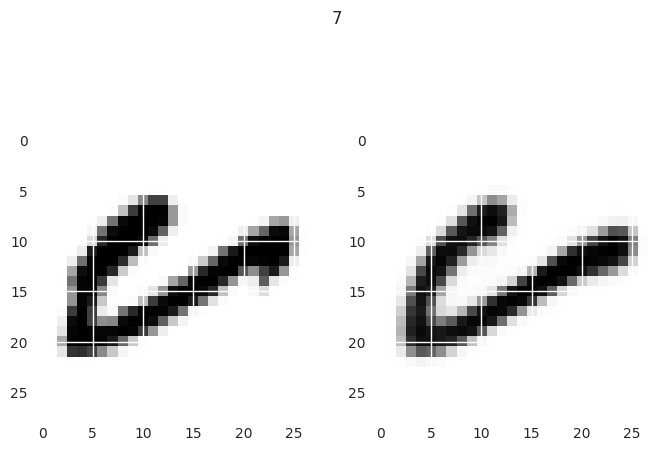

In [17]:
plot_images(2)

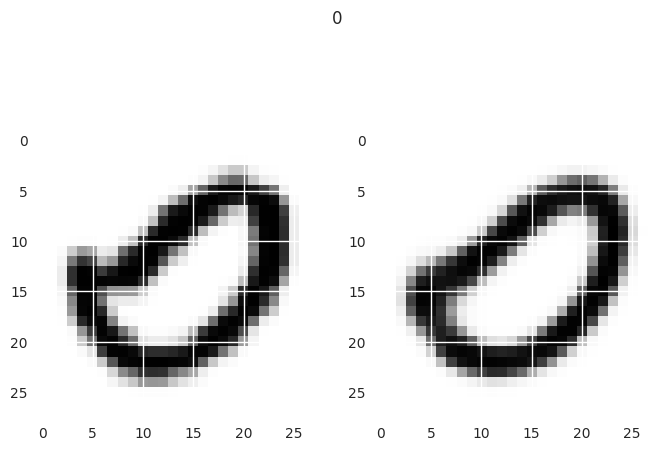

In [18]:
plot_images(8)

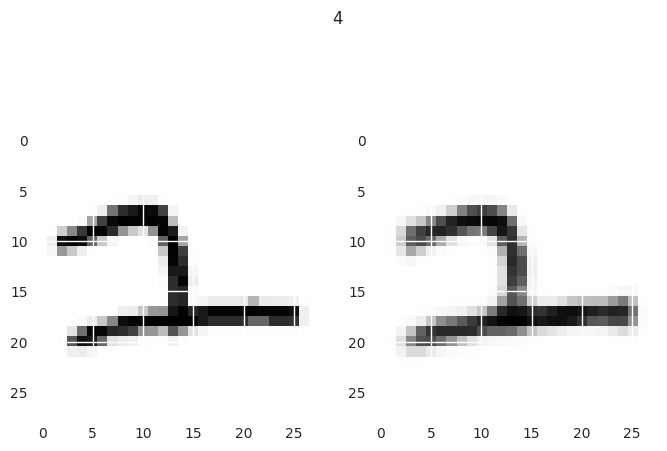

In [19]:
plot_images(80)

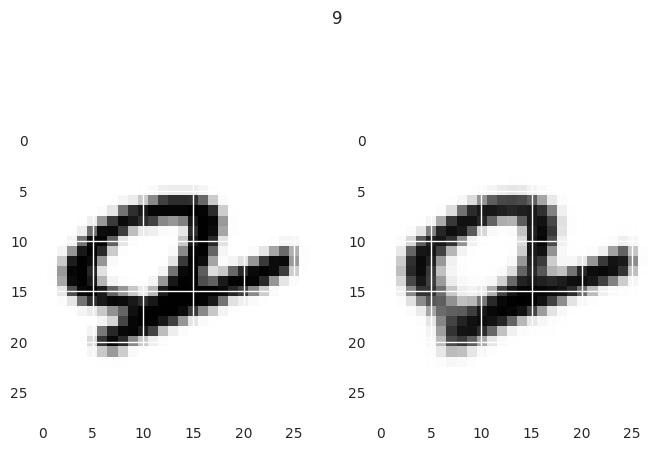

In [20]:
plot_images(90)

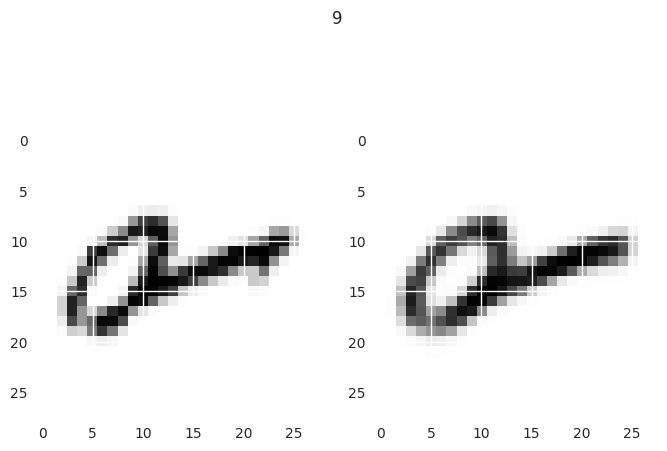

In [21]:
plot_images(100)

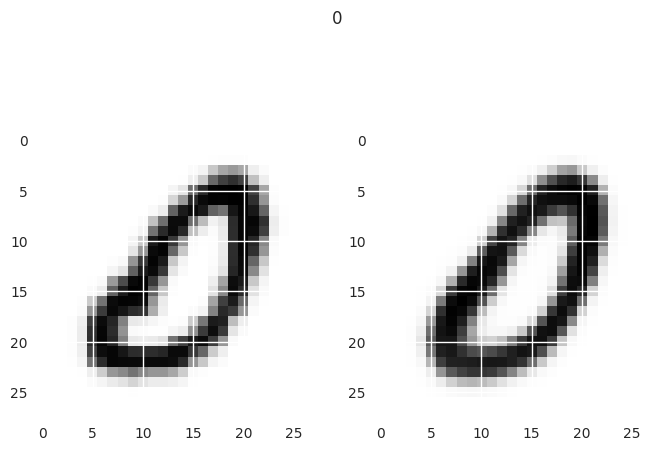

In [22]:
plot_images(1000)

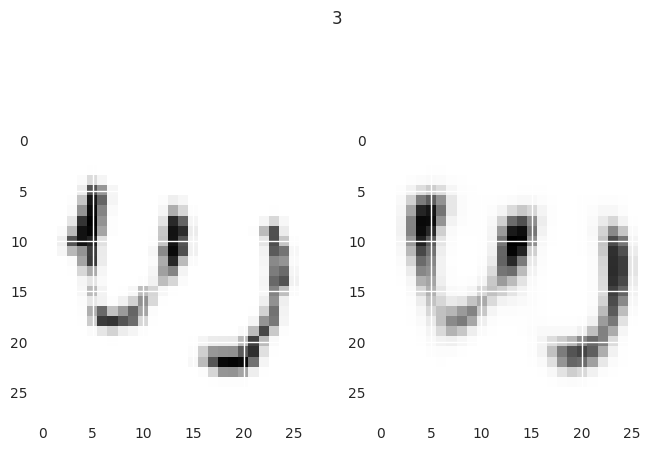

In [23]:
plot_images(1001)

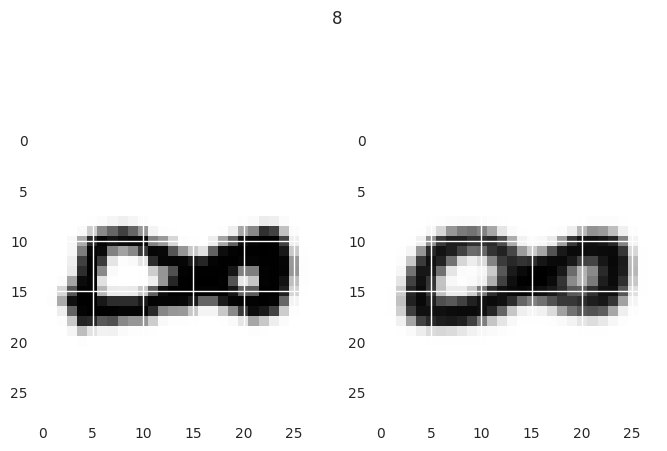

In [24]:
plot_images(1201)